In [1]:
%matplotlib inline
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from geopy.distance import vincenty
plt.rcParams['figure.figsize'] = [16, 10]



/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Lets start working on Train data. We will start with dimensions and values

As we are supposed to predict duration , I guess locations and pick up time would be import features. Lets see...


In [4]:
print(train.describe())

          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.458644e+06      1.458644e+06   1.458644e+06  
mean       -7.397342e+01      4.075180e+01   9.594923e+02  
std         7.064327e-02      3.589056e-02   5.237432e+03  
min        -1.219333e+02      3.218114e+01   1.000000e+00  
25%        -7.399133e+01

our target feature(trip_duration) has maximum of 3.526282e+06 and minimum of 1 sec. Looks like we got some outliers. We will start with Data cleaning

Step 1 : Data Cleaning

Lets remove all the trip durations that lies outside 3 std from mean.

In [5]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

In [6]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.456540e+06,1.456540e+06,1.456540e+06,1.456540e+06,1.456540e+06,1.456540e+06,1.456540e+06
mean,1.534291e+00,1.663941e+00,-7.397349e+01,4.075093e+01,-7.397342e+01,4.075180e+01,8.368576e+02
std,4.988229e-01,1.313611e+00,7.091177e-02,3.286533e-02,7.067435e-02,3.588810e-02,6.589297e+02
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073589e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075453e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396302e+01,4.076981e+01,1.073000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,1.141100e+04


Lets convert pickup_datetime to datetime format so that we can grab and store month,date and time in different columns. Any changes (Except deleting date from test ) we apply for train should also be applied to test

In [7]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)


In [8]:
train["month"] = train.pickup_datetime.dt.month
test["month"] = test.pickup_datetime.dt.month
train["hour"] = train.pickup_datetime.dt.hour
test["hour"] = test.pickup_datetime.dt.hour
train["day"] = train.pickup_datetime.dt.day
test["day"] = test.pickup_datetime.dt.day



Lets drop pickup datetime and drop off date time as we no longer need that. We dont have dropoff_Datetime in out test set

In [9]:
train = train.drop(['pickup_datetime','dropoff_datetime'],axis = 1)
test = test.drop(['pickup_datetime'],axis = 1)

Lets calculate distance between two points. We can do this with the help of geopy package.

In [10]:
def calc_distance(row):
    pickup = (row["pickup_latitude"],row["pickup_longitude"])
    dropoff = (row["dropoff_latitude"],row["dropoff_longitude"])
    distance = vincenty(pickup,dropoff).miles
    return distance

train["distance"] = train.apply(calc_distance,axis = 1)
test["distance"] = test.apply(calc_distance,axis = 1)



Since we are suppose to calculate new york date set we will remove any data that fall out of new york city. Here are the borders
longitude= (-74.03, -73.75)
latitude = (40.63, 40.85)

In [11]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

In [12]:
from sklearn.decomposition import PCA
pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

NameError: name 'coords' is not defined

Lets check if we have any kind of correlation between target variable and features

In [ ]:
corr = train.corr()
corr["trip_duration"]


As expected we can see there is a lot of correlation between distance and trip_duration


As we have done most of the date cleaning, lets do some visualtion and feature selection

Step 2 - Data Visualtization and Feature selection

lets start analyzing our target variable

In [ ]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

Clearly our target has a right skew. Lets see if we can normalize. We will take the log values of target variable

In [13]:
target = np.log(train['trip_duration'])

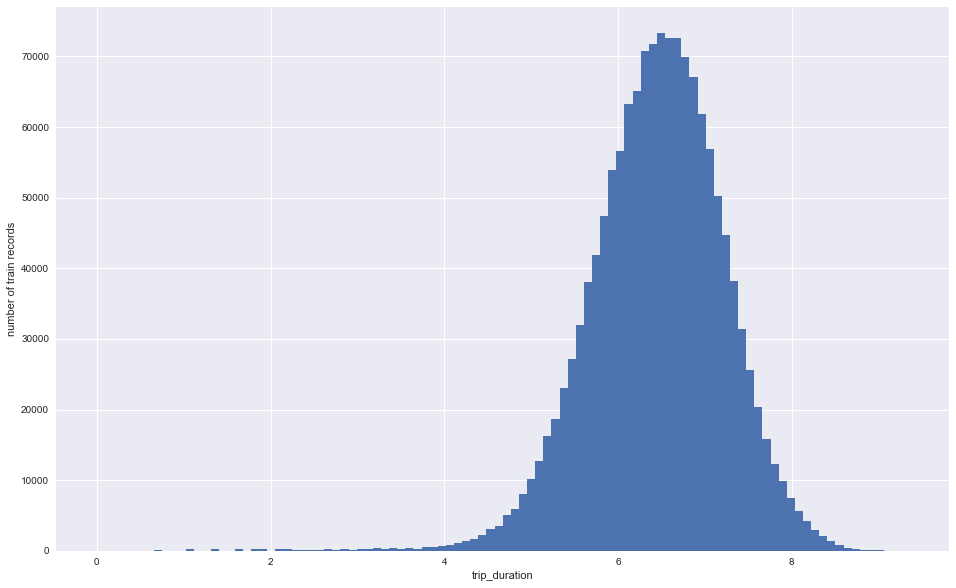

In [14]:
plt.hist(target.values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

Lets see how our distance is correlated with target variable

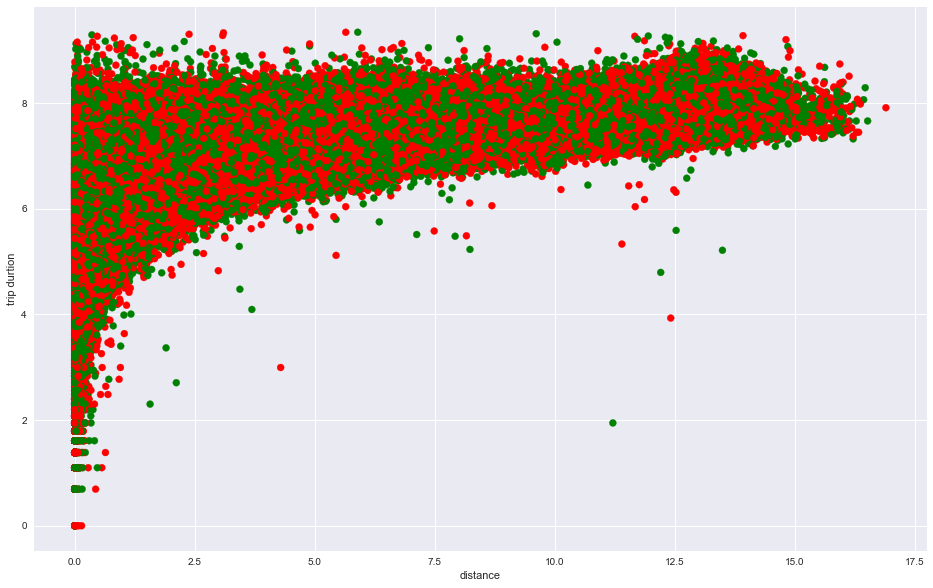

In [15]:
plt.scatter(train["distance"],target,color = ('g','r'))
plt.ylabel('trip durtion')
plt.xlabel('distance')
plt.show()

As expected trip duration and distance are highly correlated

Lets check how vendor ID affects the trip_duration


/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


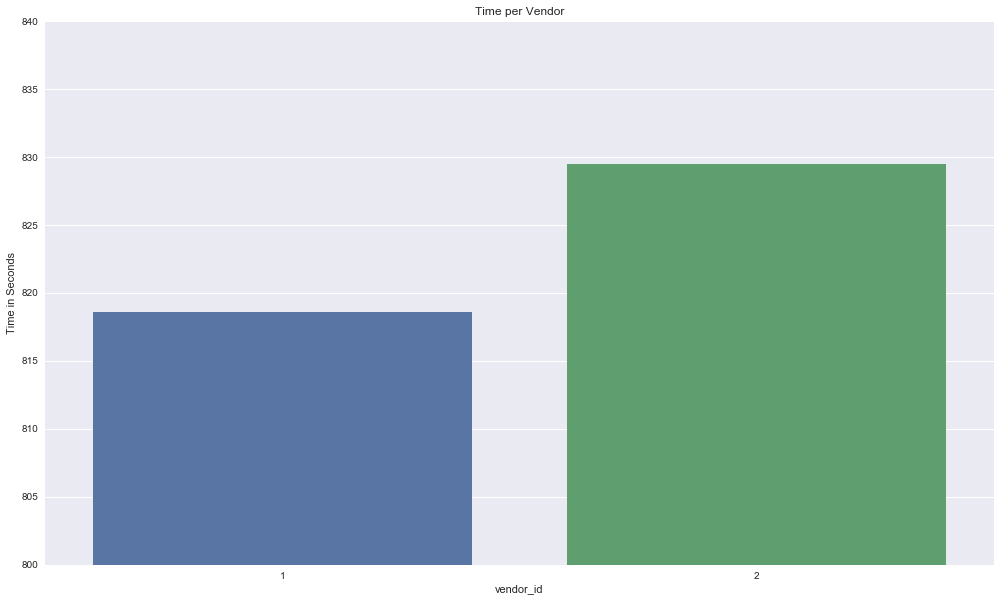

In [16]:
plot_vendor = train.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=800)
plt.ylim(ymax=840)
sns.barplot(plot_vendor.index,plot_vendor.values)
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
plt.show()

Looks like there is not much difference in the vendor_Id

Lets check passengers

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


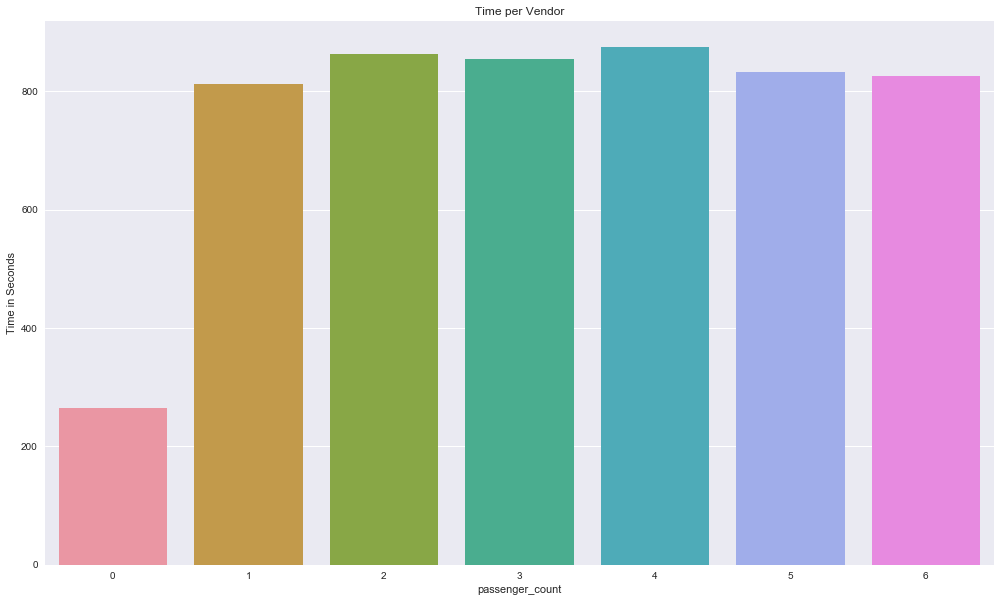

In [17]:
plot_vendor = train.groupby('passenger_count')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))

sns.barplot(plot_vendor.index,plot_vendor.values)
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
plt.show()

Dont see any kind of correlation

Lets create dummies for all the objects

In [18]:
fr1 = pd.read_csv('fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')

In [19]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [20]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [21]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [22]:
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(train['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_pickup_test = pd.get_dummies(test['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(train['dropoff_cluster'], prefix='d', prefix_sep='_')
cluster_dropoff_test = pd.get_dummies(test['dropoff_cluster'], prefix='d', prefix_sep='_')

month_train = pd.get_dummies(train['month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['day'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['day'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['hour'], prefix='h', prefix_sep='_')

In [23]:

train = train.dropna()
train.isnull().sum()

id                    0
vendor_id             0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
month                 0
hour                  0
day                   0
distance              0
total_distance        0
total_travel_time     0
number_of_steps       0
pickup_cluster        0
dropoff_cluster       0
dtype: int64

In [24]:
train = train.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','month','day','hour',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis = 1)
Test_id = test['id']
test = test.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','month','day','hour',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis = 1)



In [25]:
vendor_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1437128 entries, 0 to 1437127
Data columns (total 2 columns):
vi_1    1437128 non-null uint8
vi_2    1437128 non-null uint8
dtypes: uint8(2)
memory usage: 13.7 MB


In [26]:
train = pd.concat([train,vendor_train,
                          passenger_count_train,
                          store_and_fwd_flag_train,
                         month_train,
                         dom_train,
                          hour_train
                         ], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1437128 entries, 0 to 1437127
Data columns (total 79 columns):
trip_duration        1437127 non-null float64
distance             1437127 non-null float64
total_distance       1437127 non-null float64
total_travel_time    1437127 non-null float64
number_of_steps      1437127 non-null float64
pickup_cluster       1437127 non-null float64
dropoff_cluster      1437127 non-null float64
vi_1                 1437128 non-null uint8
vi_2                 1437128 non-null uint8
pc_0                 1437128 non-null uint8
pc_1                 1437128 non-null uint8
pc_2                 1437128 non-null uint8
pc_3                 1437128 non-null uint8
pc_4                 1437128 non-null uint8
pc_5                 1437128 non-null uint8
pc_6                 1437128 non-null uint8
sf_N                 1437128 non-null uint8
sf_Y                 1437128 non-null uint8
m_1                  1437128 non-null uint8
m_2                  1437128 non-null

In [27]:

passenger_count_test = passenger_count_test.drop('pc_9', axis = 1)

In [28]:
test = pd.concat([ test,vendor_test,
                         passenger_count_test,
                         store_and_fwd_flag_test,
                         month_test,
                         dom_test,
hour_test], axis=1)

In [29]:
from sklearn.model_selection import train_test_split
Train, Test1 = train_test_split(train[0:100000], test_size = 0.2)

In [30]:
X_train = Train.drop('trip_duration',axis = 1)
Y_train = np.log(Train["trip_duration"])
X_test = Test1.drop(['trip_duration'], axis=1)
Y_test = np.log(Test1["trip_duration"])

Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

In [31]:

xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}

lr = Ridge(50)

ridge_model = lr.fit(X_train, Y_train)
preds_ridge = ridge_model.predict(X_test)
mse = mean_squared_error(preds_ridge,Y_test)
rmse = mse ** 0.5
rmse

0.51084692819187305

In [32]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)
dtest = xgb.DMatrix(test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [33]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 10, watchlist, early_stopping_rounds=2,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:3.02328	valid-rmse:3.02566
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:1.55817	valid-rmse:1.56114
[2]	train-rmse:0.862702	valid-rmse:0.867311
[3]	train-rmse:0.563468	valid-rmse:0.571618
[4]	train-rmse:0.455463	valid-rmse:0.467566
[5]	train-rmse:0.421302	valid-rmse:0.43663
[6]	train-rmse:0.409526	valid-rmse:0.427125
[7]	train-rmse:0.403525	valid-rmse:0.423044
[8]	train-rmse:0.399725	valid-rmse:0.420555
[9]	train-rmse:0.395381	valid-rmse:0.418244
Modeling RMSLE 0.41824


In [38]:

pred = model.predict(dtest)
pred = np.exp(pred)

In [39]:
print(pred)

[  817.14868164   559.96630859   335.73809814 ...,  1196.59399414
  2222.91772461  1122.72949219]


In [40]:
submission = pd.concat([Test_id, pd.DataFrame(pred)], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("submission.csv", index=False)